In [73]:
import pyxdf
import mne
from mne.decoding import CSP
from mne.preprocessing import EOGRegression
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split

from mnetools import streams2mnedata, preprocessing

In [74]:
# -- |Data details| --
participant_id = 4
session = 3
# -- |Data Selection| --
initial_run = 1
n_run = 5

# -- |Parameters| --
tmin= -0.5
tmax= 3

# -- |Event dictionary| --
# Set up your event name
if session == 1 : events_id = {'right': 0, 'left': 1}
else            : events_id = {'none': 0, 'right': 1, 'left': 2}

# **Raw Data Overview**

In [75]:
# -- |Local parameters|--
epochs_list = [] 

for i in range(initial_run,initial_run+n_run):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P{participant_id:003d}/ses-S{session:003d}/eeg/sub-P{participant_id:003d}_ses-S{session:003d}_task-Default_run-{i:003d}_eeg.xdf") #Example Data from Lab Recoder

    raw_mne, events = streams2mnedata(streams)
    epochs = mne.Epochs(raw_mne, events, tmin= -0.5,  tmax= 3, event_id = events_id, preload = True,verbose=False,picks = ['C3','Cz','C4','PO7','Pz','PO8','EOG'])

    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

Number of events,203
Events,left: 68none: 68right: 67
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


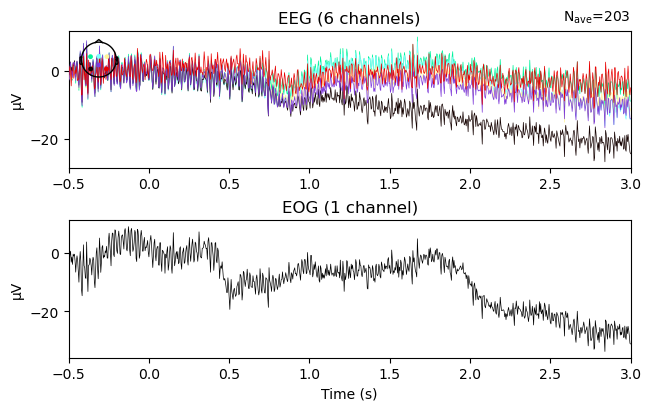

In [76]:
plot_kwargs = dict(picks="all")

# plot the evoked for the EEG and the EOG sensors
fig = epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


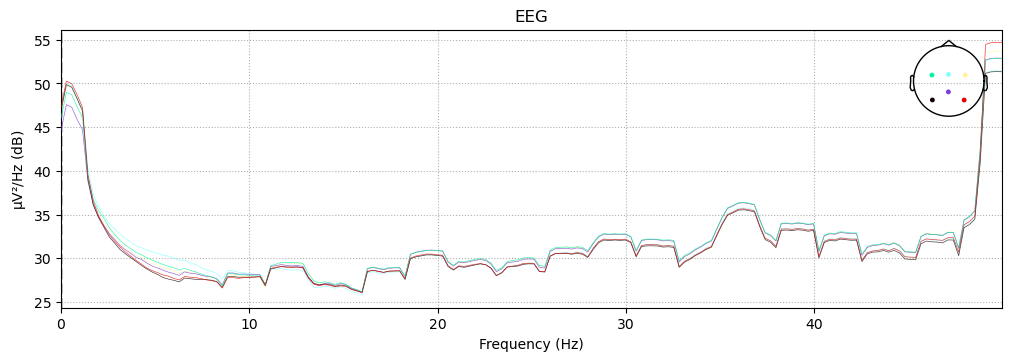

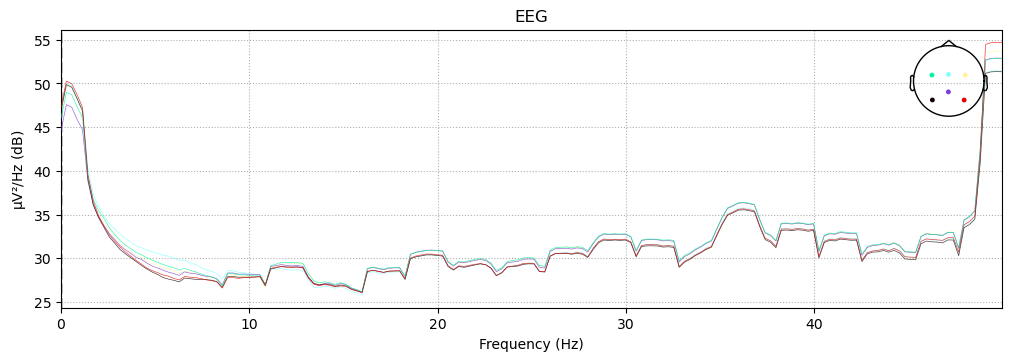

In [77]:
epochs.compute_psd(fmin=0,fmax=50).plot()

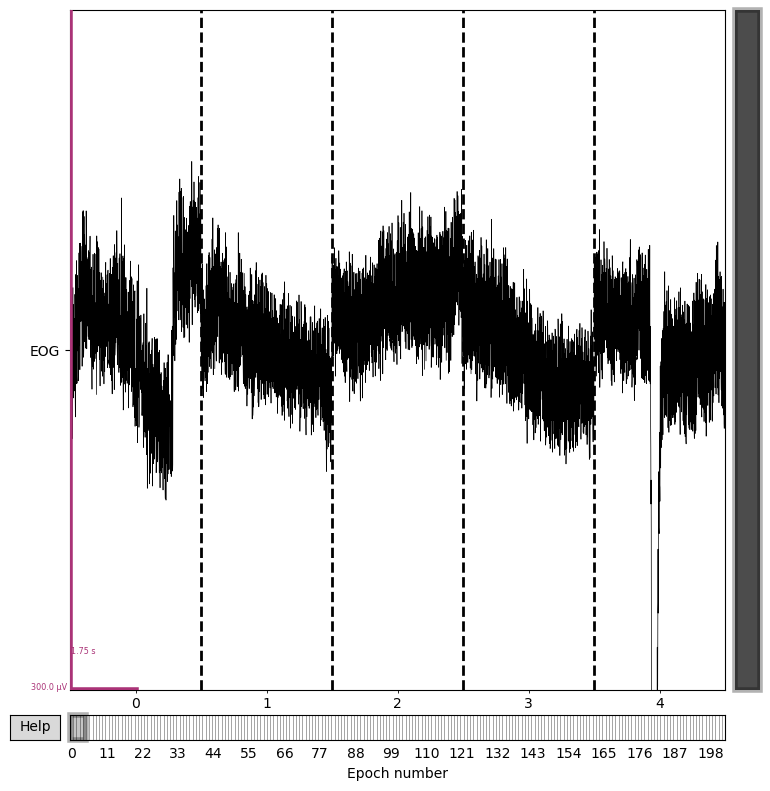

In [78]:
epochs.plot(picks='EOG', n_epochs=5);

# **Processing**

In [79]:
# -- |Local parameters|--
epochs_list = [] 

for i in range(initial_run,initial_run+n_run):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P{participant_id:003d}/ses-S{session:003d}/eeg/sub-P{participant_id:003d}_ses-S{session:003d}_task-Default_run-{i:003d}_eeg.xdf") #Example Data from Lab Recoder

    raw_mne, events = streams2mnedata(streams)
    prepro_mne = preprocessing(raw_mne)
    
    # -- |Epoch Segmentation| --
    epochs = mne.Epochs(prepro_mne, events, tmin= tmin,  tmax= tmax, event_id = events_id, preload = True,verbose=False,picks = ['C3','Cz','C4','PO7','Pz','PO8','EOG'])

    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

Number of events,203
Events,left: 68none: 68right: 67
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


## Part 1: Without artifact removal

### 1.1 Left vs. Right Classification

#### 1.1.1 SVM

Train set shape: (108, 7, 876)
Test set shape : (27, 7, 876)
Using all features ----------------------------------------------


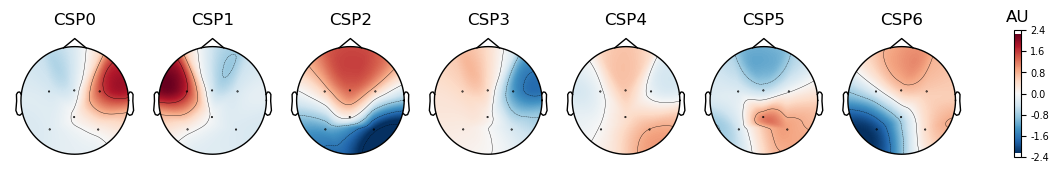

Train Accuracy: 0.7962962962962963
Test  Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

       right       0.61      0.85      0.71        13
        left       0.78      0.50      0.61        14

    accuracy                           0.67        27
   macro avg       0.69      0.67      0.66        27
weighted avg       0.70      0.67      0.66        27

Using features which yield maximum accuracy----------------------
Train set shape: (108, 7, 876)
Test set shape : (27, 7, 876)


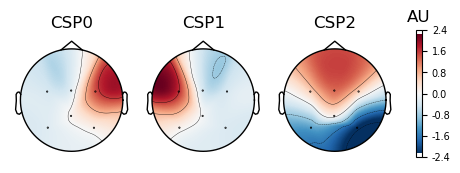

Train Accuracy: 0.7870370370370371
Test  Accuracy: 0.7777777777777778
              precision    recall  f1-score   support

       right       0.68      1.00      0.81        13
        left       1.00      0.57      0.73        14

    accuracy                           0.78        27
   macro avg       0.84      0.79      0.77        27
weighted avg       0.85      0.78      0.77        27



In [80]:
mne.set_log_level(verbose=False)

# Get EEG data and events
X = epochs[['right','left']].get_data(copy=False)
Y = epochs[['right','left']].events[:, -1]

csp_list = []
svm_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Fit CSP to data 
    csp.fit(X_train,Y_train)
    csp_list.append(csp)

    # Transform data into CSP space
    X_train_transformed = csp.transform(X_train)
    X_test_transformed = csp.transform(X_test)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train_transformed, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test_transformed)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, svm.predict(X_train_transformed)))

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 1.1.2 Logistic Regression

Using all features ----------------------------------------------
Train set shape: (108, 7)
Test set shape : (27, 7)


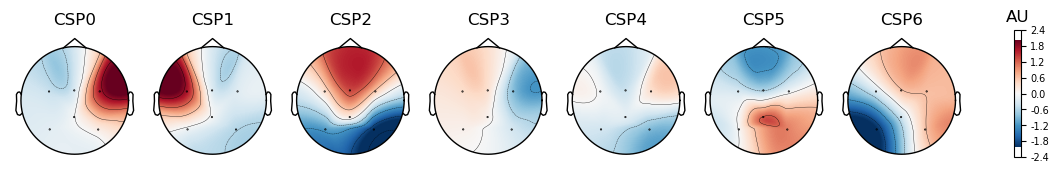

Train Accuracy: 0.8518518518518519
Test  Accuracy: 0.7777777777777778
              precision    recall  f1-score   support

  none-right       0.71      0.92      0.80        13
       right       0.90      0.64      0.75        14

    accuracy                           0.78        27
   macro avg       0.80      0.78      0.78        27
weighted avg       0.81      0.78      0.77        27

Using features which yield maximum accuracy----------------------
Train set shape: (108, 7)
Test set shape : (27, 7)


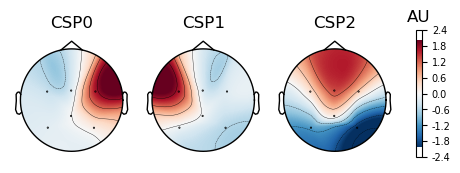

Train Accuracy: 0.8148148148148148
Test  Accuracy: 0.8148148148148148
              precision    recall  f1-score   support

  none-right       0.75      0.92      0.83        13
       right       0.91      0.71      0.80        14

    accuracy                           0.81        27
   macro avg       0.83      0.82      0.81        27
weighted avg       0.83      0.81      0.81        27



In [81]:
csp_list = []
lr_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, lr.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 1.2 Left vs. Non-left Classification

#### 1.2.1 SVM

Using all features ----------------------------------------------
Train set shape: (162, 7)
Test set shape : (41, 7)


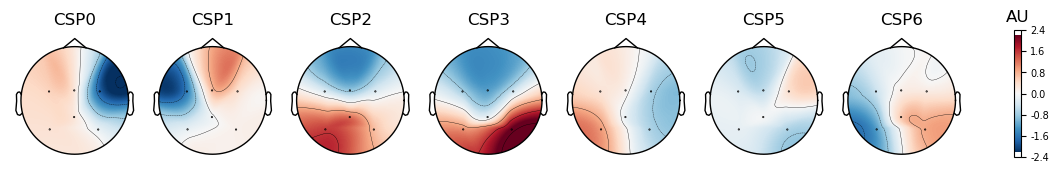

Train Accuracy: 0.7345679012345679
Test  Accuracy: 0.7317073170731707
              precision    recall  f1-score   support

       right       0.74      0.93      0.82        27
        left       0.71      0.36      0.48        14

    accuracy                           0.73        41
   macro avg       0.72      0.64      0.65        41
weighted avg       0.73      0.73      0.70        41

Using features which yield maximum accuracy----------------------
Train set shape: (162, 7)
Test set shape : (41, 7)


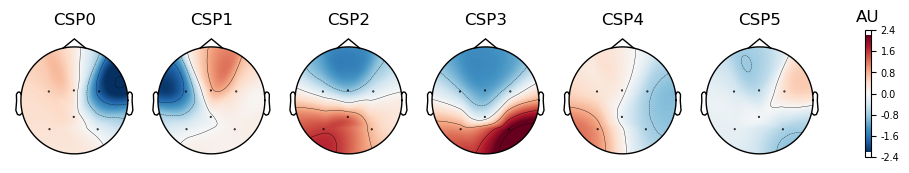

Train Accuracy: 0.7407407407407407
Test  Accuracy: 0.7560975609756098
              precision    recall  f1-score   support

       right       0.74      0.96      0.84        27
        left       0.83      0.36      0.50        14

    accuracy                           0.76        41
   macro avg       0.79      0.66      0.67        41
weighted avg       0.77      0.76      0.72        41



In [82]:
epochs_l = epochs.copy()
epochs_l.events = mne.merge_events(epochs_l.events, [0, 1], 0, replace_events=True)
epochs_l.event_id = {'none-left': 0, 'left': 2}

# Get EEG data and events
X = epochs_l.get_data(copy=False)
Y = epochs_l.events[:, -1]

csp_list = []
svm_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, svm.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 1.2.2 Logistic Regression

Using all features ----------------------------------------------
Train set shape: (162, 7)
Test set shape : (41, 7)


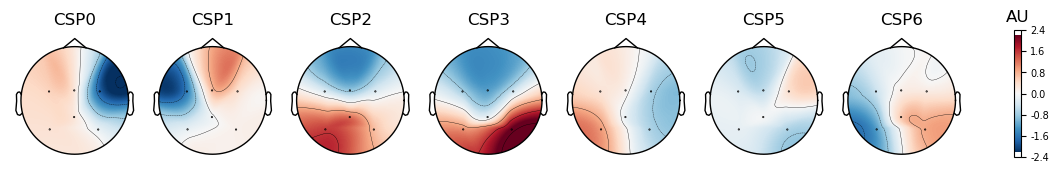

Train Accuracy: 0.7469135802469136
Test  Accuracy: 0.7560975609756098
              precision    recall  f1-score   support

  none-right       0.76      0.93      0.83        27
       right       0.75      0.43      0.55        14

    accuracy                           0.76        41
   macro avg       0.75      0.68      0.69        41
weighted avg       0.75      0.76      0.74        41

Using features which yield maximum accuracy----------------------
Train set shape: (162, 7)
Test set shape : (41, 7)


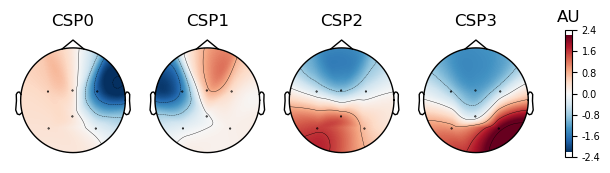

Train Accuracy: 0.7592592592592593
Test  Accuracy: 0.7560975609756098
              precision    recall  f1-score   support

  none-right       0.76      0.93      0.83        27
       right       0.75      0.43      0.55        14

    accuracy                           0.76        41
   macro avg       0.75      0.68      0.69        41
weighted avg       0.75      0.76      0.74        41



In [83]:
csp_list = []
lr_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, lr.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 1.3 Right vs. Non-Right Classification

#### 1.3.1 SVM

c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\li

Using all features ----------------------------------------------
Train set shape: (162, 7)
Test set shape : (41, 7)


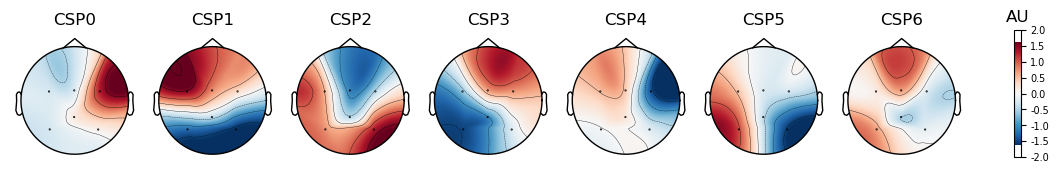

Train Accuracy: 0.6728395061728395
Test  Accuracy: 0.6585365853658537
              precision    recall  f1-score   support

       right       0.66      1.00      0.79        27
        left       0.00      0.00      0.00        14

    accuracy                           0.66        41
   macro avg       0.33      0.50      0.40        41
weighted avg       0.43      0.66      0.52        41

Using features which yield maximum accuracy----------------------
Train set shape: (162, 7)
Test set shape : (41, 7)


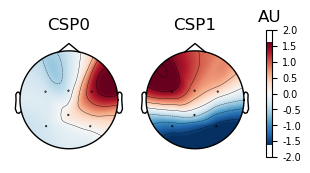

Train Accuracy: 0.6728395061728395
Test  Accuracy: 0.6585365853658537
              precision    recall  f1-score   support

       right       0.66      1.00      0.79        27
        left       0.00      0.00      0.00        14

    accuracy                           0.66        41
   macro avg       0.33      0.50      0.40        41
weighted avg       0.43      0.66      0.52        41



In [84]:
epochs_r = epochs.copy()
epochs_r.events = mne.merge_events(epochs_r.events, [0, 2], 0, replace_events=True)
epochs_r.event_id = {'none-right': 0, 'right': 1}

# Get EEG data and events
X = epochs_r.get_data(copy=False)
Y = epochs_r.events[:, -1]

csp_list = []
svm_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, svm.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 1.3.2 Logistic Regression

Using all features ----------------------------------------------
Train set shape: (162, 7)
Test set shape : (41, 7)


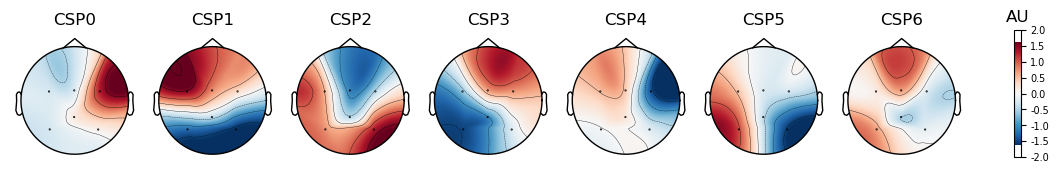

Train Accuracy: 0.6851851851851852
Test  Accuracy: 0.6829268292682927
              precision    recall  f1-score   support

  none-right       0.69      0.93      0.79        27
       right       0.60      0.21      0.32        14

    accuracy                           0.68        41
   macro avg       0.65      0.57      0.55        41
weighted avg       0.66      0.68      0.63        41

Using features which yield maximum accuracy----------------------
Train set shape: (162, 7)
Test set shape : (41, 7)


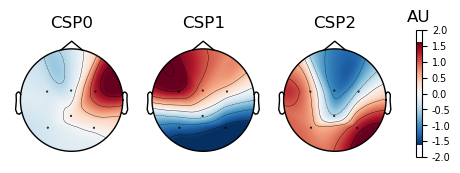

Train Accuracy: 0.691358024691358
Test  Accuracy: 0.6829268292682927
              precision    recall  f1-score   support

  none-right       0.69      0.93      0.79        27
       right       0.60      0.21      0.32        14

    accuracy                           0.68        41
   macro avg       0.65      0.57      0.55        41
weighted avg       0.66      0.68      0.63        41



In [85]:
csp_list = []
lr_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, lr.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

## Part 2: With artifact removal

### Artifact Correlations

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_67216\2921723998.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_67216\2921723998.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


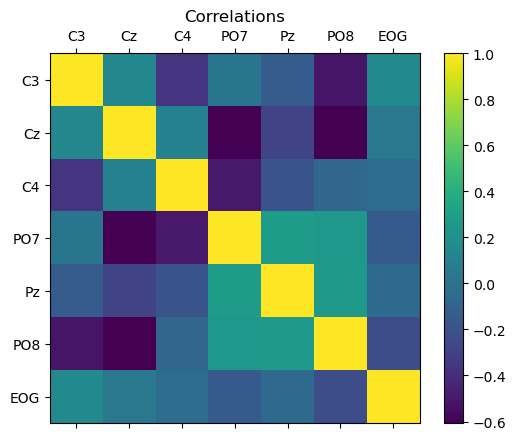

,C3,Cz,C4,PO7,Pz,PO8,EOG
C3,1.000000,0.143086,-0.365438,0.015580,-0.137143,-0.513942,0.165215
Cz,0.143086,1.000000,0.097463,-0.602235,-0.279312,-0.606509,0.034925
C4,-0.365438,0.097463,1.000000,-0.499011,-0.187104,-0.077573,-0.036638
PO7,0.015580,-0.602235,-0.499011,1.000000,0.275687,0.252771,-0.150848
Pz,-0.137143,-0.279312,-0.187104,0.275687,1.000000,0.262177,-0.056871
PO8,-0.513942,-0.606509,-0.077573,0.252771,0.262177,1.000000,-0.227171
EOG,0.165215,0.034925,-0.036638,-0.150848,-0.056871,-0.227171,1.000000


In [86]:
df = epochs.to_data_frame()
df_numerical = df[epochs.ch_names]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df_numerical.corr(), interpolation='nearest')
fig.colorbar(cax)

alpha = epochs.ch_names
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
ax.set_title('Correlations')

plt.show()
df_numerical.corr()

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_67216\3594465532.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_67216\3594465532.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


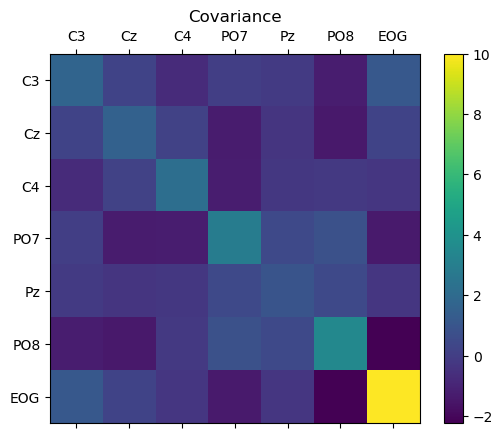

,C3,Cz,C4,PO7,Pz,PO8,EOG
C3,1.712161,0.233211,-0.709853,0.034805,-0.175766,-1.253767,1.138991
Cz,0.233211,1.551523,0.180219,-1.280719,-0.340768,-1.408466,0.229201
C4,-0.709853,0.180219,2.203757,-1.264738,-0.272054,-0.214696,-0.286559
PO7,0.034805,-1.280719,-1.264738,2.914856,0.461015,0.804573,-1.356901
Pz,-0.175766,-0.340768,-0.272054,0.461015,0.959355,0.478756,-0.293482
PO8,-1.253767,-1.408466,-0.214696,0.804573,0.478756,3.475843,-2.231426
EOG,1.138991,0.229201,-0.286559,-1.356901,-0.293482,-2.231426,27.758694


In [87]:
df = epochs.to_data_frame()
df_numerical = df[epochs.ch_names]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df_numerical.cov(), interpolation='nearest',vmax=10)
fig.colorbar(cax)

alpha = epochs.ch_names
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
ax.set_title('Covariance')

plt.show()
df_numerical.cov()

In [88]:
df_numerical.corr()['EOG'][:-1].mul(df_numerical.std().iloc[:-1]/df_numerical.std().iloc[-1])

C3     0.041032
Cz     0.008257
C4    -0.010323
PO7   -0.048882
Pz    -0.010573
PO8   -0.080387
dtype: float64

### 2.1 Visualize Original Data

#### Signal Average Over Epochs

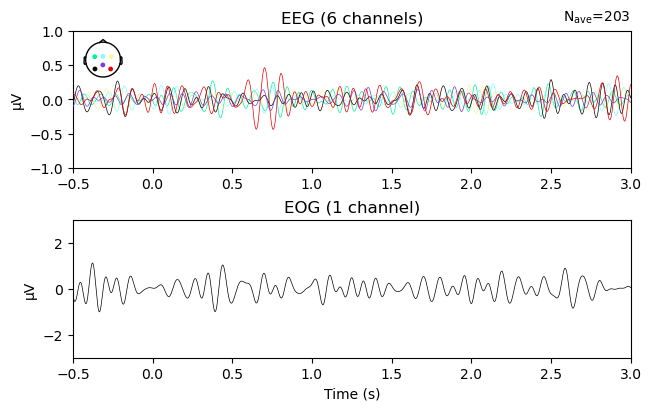

In [89]:
plot_kwargs = dict(picks="all", ylim=dict(eeg=(-1, 1), eog=(-3, 3)))

# plot the evoked for the EEG and the EOG sensors
fig = epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

#### Time Domain Plot

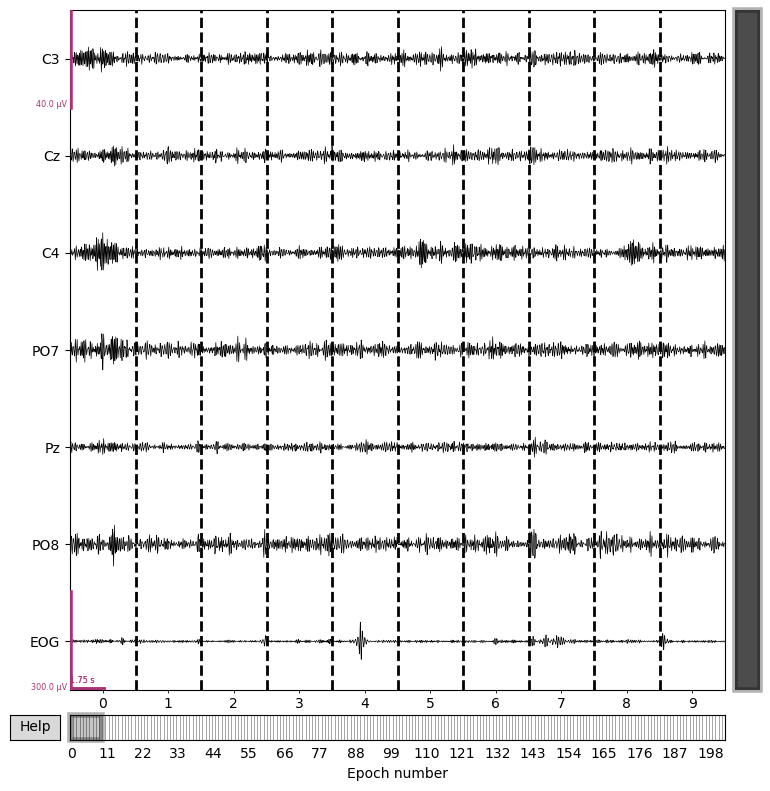

In [90]:
epochs.plot(picks='all', n_epochs=10);

### 2.2 Compute and Apply EOG Regression

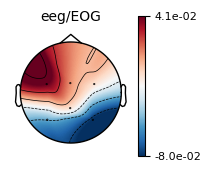

In [91]:
# Perform regression using the EOG sensor as independent variable and the EEG
# sensors as dependent variables.
model_plain = EOGRegression(picks="eeg", picks_artifact="eog").fit(epochs)

epochs_clean_plain = model_plain.apply(epochs)
# After regression, we should redo the baseline correction
epochs_clean_plain.apply_baseline()

fig = model_plain.plot()  # regression coefficients as topomap
fig.set_size_inches(3, 2)

In [92]:
model_plain.coef_

array([[ 0.04114612],
       [ 0.0082421 ],
       [-0.01033696],
       [-0.04887394],
       [-0.0105333 ],
       [-0.08047428]])

#### Signal Average Over Epochs

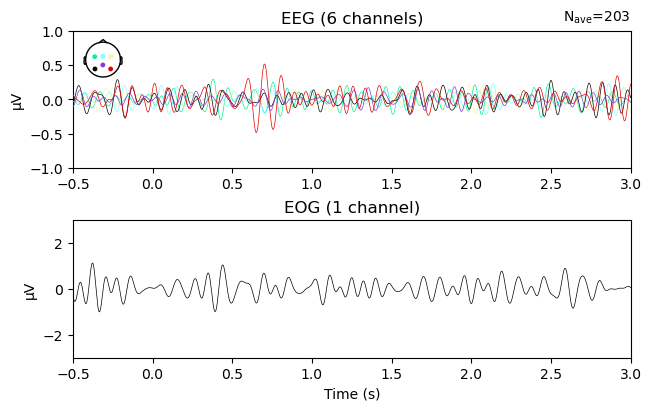

In [93]:
# Show the evoked potential computed on the corrected data
fig = epochs_clean_plain.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

#### Time Domain Plot

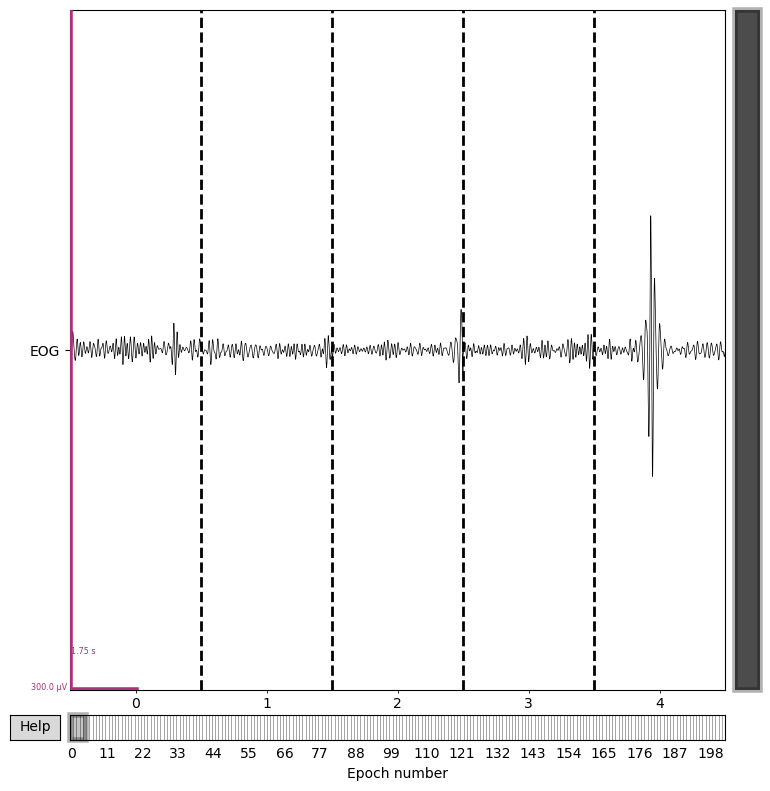

In [94]:
epochs_clean_plain.plot(picks='EOG', n_epochs=5);

### 2.3 Left vs. Right Classification

#### 2.3.1 SVM

Using all features ----------------------------------------------
Train set shape: (108, 7)
Test set shape : (27, 7)


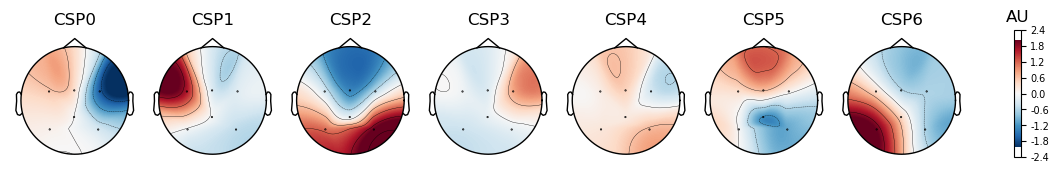

Train Accuracy: 0.8333333333333334
Test  Accuracy: 0.7777777777777778
              precision    recall  f1-score   support

       right       0.71      0.92      0.80        13
        left       0.90      0.64      0.75        14

    accuracy                           0.78        27
   macro avg       0.80      0.78      0.78        27
weighted avg       0.81      0.78      0.77        27

Using features which yield maximum accuracy----------------------
Train set shape: (108, 7)
Test set shape : (27, 7)


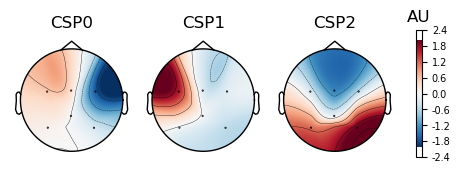

Train Accuracy: 0.8148148148148148
Test  Accuracy: 0.8148148148148148
              precision    recall  f1-score   support

       right       0.75      0.92      0.83        13
        left       0.91      0.71      0.80        14

    accuracy                           0.81        27
   macro avg       0.83      0.82      0.81        27
weighted avg       0.83      0.81      0.81        27



In [95]:
# Get EEG data and events
X = epochs_clean_plain[['right','left']].get_data(copy=False)
Y = epochs_clean_plain[['right','left']].events[:, -1]

csp_list = []
svm_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, svm.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 2.3.2 Logistic Regression

Using all features ----------------------------------------------
Train set shape: (108, 7)
Test set shape : (27, 7)


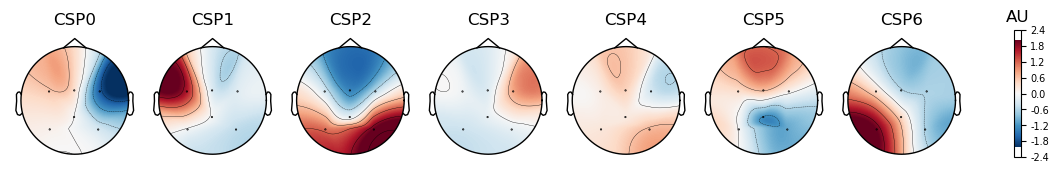

Train Accuracy: 0.8518518518518519
Test  Accuracy: 0.7777777777777778
              precision    recall  f1-score   support

  none-right       0.71      0.92      0.80        13
       right       0.90      0.64      0.75        14

    accuracy                           0.78        27
   macro avg       0.80      0.78      0.78        27
weighted avg       0.81      0.78      0.77        27

Using features which yield maximum accuracy----------------------
Train set shape: (108, 7)
Test set shape : (27, 7)


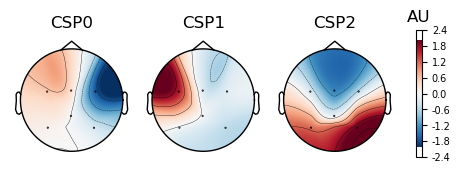

Train Accuracy: 0.8148148148148148
Test  Accuracy: 0.8148148148148148
              precision    recall  f1-score   support

  none-right       0.75      0.92      0.83        13
       right       0.91      0.71      0.80        14

    accuracy                           0.81        27
   macro avg       0.83      0.82      0.81        27
weighted avg       0.83      0.81      0.81        27



In [96]:
csp_list = []
lr_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, lr.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 2.4 Left vs. Non-left Classification

#### 2.4.1 SVM

Using all features ----------------------------------------------
Train set shape: (162, 7)
Test set shape : (41, 7)


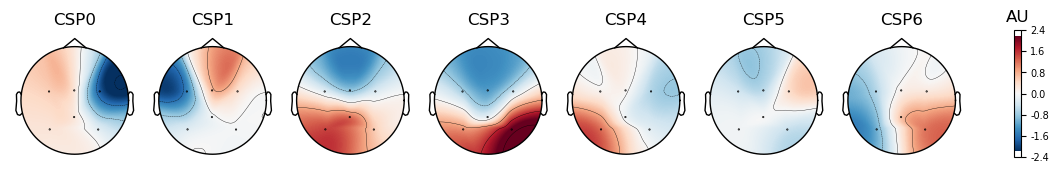

Train Accuracy: 0.7345679012345679
Test  Accuracy: 0.7317073170731707
              precision    recall  f1-score   support

       right       0.74      0.93      0.82        27
        left       0.71      0.36      0.48        14

    accuracy                           0.73        41
   macro avg       0.72      0.64      0.65        41
weighted avg       0.73      0.73      0.70        41

Using features which yield maximum accuracy----------------------
Train set shape: (162, 7)
Test set shape : (41, 7)


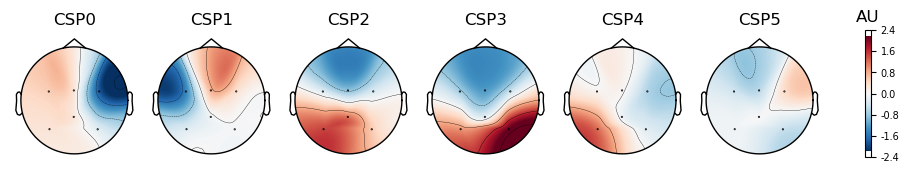

Train Accuracy: 0.7407407407407407
Test  Accuracy: 0.7560975609756098
              precision    recall  f1-score   support

       right       0.74      0.96      0.84        27
        left       0.83      0.36      0.50        14

    accuracy                           0.76        41
   macro avg       0.79      0.66      0.67        41
weighted avg       0.77      0.76      0.72        41



In [97]:
epochs_clean_plain_l = epochs_clean_plain.copy()
epochs_clean_plain_l.events = mne.merge_events(epochs_clean_plain_l.events, [0, 1], 0, replace_events=True)
epochs_clean_plain_l.event_id = {'none-left': 0, 'left': 2}

# Get EEG data and events
X = epochs_clean_plain_l.get_data(copy=False)
Y = epochs_clean_plain_l.events[:, -1]

csp_list = []
svm_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, svm.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 2.4.2 Logistic Regression

Using all features ----------------------------------------------
Train set shape: (162, 7)
Test set shape : (41, 7)


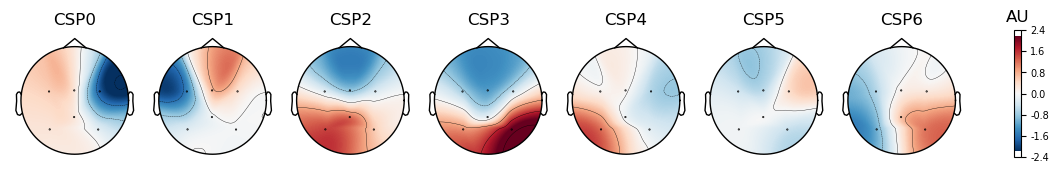

Train Accuracy: 0.7469135802469136
Test  Accuracy: 0.7560975609756098
              precision    recall  f1-score   support

  none-right       0.76      0.93      0.83        27
       right       0.75      0.43      0.55        14

    accuracy                           0.76        41
   macro avg       0.75      0.68      0.69        41
weighted avg       0.75      0.76      0.74        41

Using features which yield maximum accuracy----------------------
Train set shape: (162, 7)
Test set shape : (41, 7)


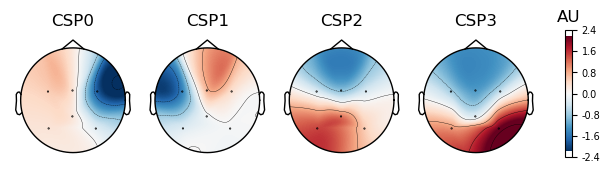

Train Accuracy: 0.7592592592592593
Test  Accuracy: 0.7560975609756098
              precision    recall  f1-score   support

  none-right       0.76      0.93      0.83        27
       right       0.75      0.43      0.55        14

    accuracy                           0.76        41
   macro avg       0.75      0.68      0.69        41
weighted avg       0.75      0.76      0.74        41



In [98]:
csp_list = []
lr_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, lr.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 2.5 Right vs. Non-Right Classification

#### 2.5.1 SVM

c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AbsoluteZeno\anaconda3\li

Using all features ----------------------------------------------
Train set shape: (162, 7)
Test set shape : (41, 7)


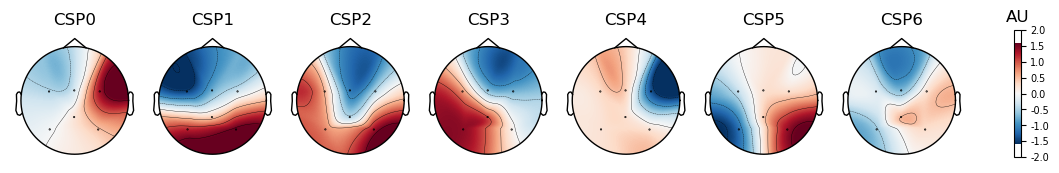

Train Accuracy: 0.6728395061728395
Test  Accuracy: 0.6585365853658537
              precision    recall  f1-score   support

       right       0.66      1.00      0.79        27
        left       0.00      0.00      0.00        14

    accuracy                           0.66        41
   macro avg       0.33      0.50      0.40        41
weighted avg       0.43      0.66      0.52        41

Using features which yield maximum accuracy----------------------
Train set shape: (162, 7)
Test set shape : (41, 7)


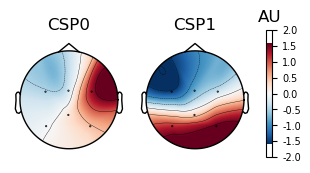

Train Accuracy: 0.6728395061728395
Test  Accuracy: 0.6585365853658537
              precision    recall  f1-score   support

       right       0.66      1.00      0.79        27
        left       0.00      0.00      0.00        14

    accuracy                           0.66        41
   macro avg       0.33      0.50      0.40        41
weighted avg       0.43      0.66      0.52        41



In [99]:
epochs_clean_plain_r = epochs_clean_plain.copy()
epochs_clean_plain_r.events = mne.merge_events(epochs_clean_plain_r.events, [0, 2], 0, replace_events=True)
epochs_clean_plain_r.event_id = {'none-right': 0, 'right': 1}

# Get EEG data and events
X = epochs_clean_plain_r.get_data(copy=False)
Y = epochs_clean_plain_r.events[:, -1]

csp_list = []
svm_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, svm.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 2.5.2 Logistic Regression

Using all features ----------------------------------------------
Train set shape: (162, 7)
Test set shape : (41, 7)


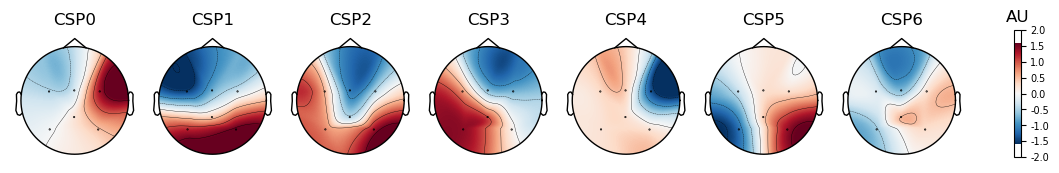

Train Accuracy: 0.6851851851851852
Test  Accuracy: 0.6829268292682927
              precision    recall  f1-score   support

  none-right       0.69      0.93      0.79        27
       right       0.60      0.21      0.32        14

    accuracy                           0.68        41
   macro avg       0.65      0.57      0.55        41
weighted avg       0.66      0.68      0.63        41

Using features which yield maximum accuracy----------------------
Train set shape: (162, 7)
Test set shape : (41, 7)


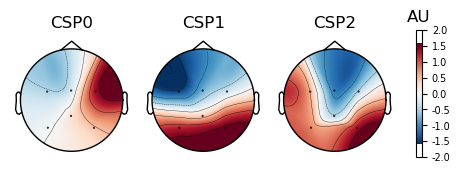

Train Accuracy: 0.691358024691358
Test  Accuracy: 0.6829268292682927
              precision    recall  f1-score   support

  none-right       0.69      0.93      0.79        27
       right       0.60      0.21      0.32        14

    accuracy                           0.68        41
   macro avg       0.65      0.57      0.55        41
weighted avg       0.66      0.68      0.63        41



In [100]:
csp_list = []
lr_list = []
acc_train_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    acc_train_list.append(accuracy_score(Y_train, lr.predict(X_train)))

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

print("Using all features ----------------------------------------------")
ind = len(acc_list) - 1

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])

# -- |Select CSP which gives maximum accuracy| --
print("Using features which yield maximum accuracy----------------------")
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Train Accuracy: {acc_train_list[ind]}")
print(f"Test  Accuracy: {acc_list[ind]}")
print(report_list[ind])